# Load Spatial Data and Merge with R Data for Modeling
Prep data for R modeling

## Download Spatial Data

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

import helpers
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import pysal as ps
import geopandas as gpd
from osgeo import ogr 
# for osgeo, dont use pip - instead 'conda install gdal'
# OR DO THIS https://varunpant.com/posts/gdal-2-on-mac-with-homebrew
from pylab import *
import sys
import platform
import zipfile
import os
from datetime import datetime

#from mpl_toolkits.basemap import Basemap 
# conda install -c conda-forge basemap 
# conda install -c conda-forge basemap-data-hires

from lxml import etree
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
#from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain
import pickle

print(sys.version_info)
print("Python Version: " + str(platform.python_version()))

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
Python Version: 3.7.3


In [15]:
from census import Census
from us import states
import config

In [16]:
c = Census(config.api_secret)

In [17]:
!!states CA

['',
 '*** The great state of California (CA) ***',
 '',
 '  FIPS code: 06',
 '',
 '  other attributes:',
 '    ap_abbr: Calif.',
 '    capital: Sacramento',
 '    capital_tz: America/Los_Angeles',
 '    is_contiguous: True',
 '    is_continental: True',
 '    is_obsolete: False',
 '    name_metaphone: KLFRN',
 '    statehood_year: 1850',
 '    time_zones: America/Los_Angeles',
 '',
 '  shapefiles:',
 '    tract: https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_06_tract10.zip',
 '    cd: https://www2.census.gov/geo/tiger/TIGER2010/CD/111/tl_2010_06_cd111.zip',
 '    county: https://www2.census.gov/geo/tiger/TIGER2010/COUNTY/2010/tl_2010_06_county10.zip',
 '    state: https://www2.census.gov/geo/tiger/TIGER2010/STATE/2010/tl_2010_06_state10.zip',
 '    zcta: https://www2.census.gov/geo/tiger/TIGER2010/ZCTA5/2010/tl_2010_06_zcta510.zip',
 '    block: https://www2.census.gov/geo/tiger/TIGER2010/TABBLOCK/2010/tl_2010_06_tabblock10.zip',
 '    blockgroup: https://www2.census.g

In [18]:
#!!wget https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_06_tract10.zip

In [19]:
import geopandas as gpd
shapefile = gpd.read_file("tl_2010_06_tract10/tl_2010_06_tract10.shp")
shapefile = shapefile.query("COUNTYFP10=='075'")
shapefile.index = list(range(shapefile.shape[0])) # GEOID10 is match with R 
print(shapefile)

    STATEFP10 COUNTYFP10 TRACTCE10      GEOID10  NAME10           NAMELSAD10  \
0          06        075    016500  06075016500     165     Census Tract 165   
1          06        075    016400  06075016400     164     Census Tract 164   
2          06        075    016300  06075016300     163     Census Tract 163   
3          06        075    016100  06075016100     161     Census Tract 161   
4          06        075    016000  06075016000     160     Census Tract 160   
5          06        075    015900  06075015900     159     Census Tract 159   
6          06        075    015700  06075015700     157     Census Tract 157   
7          06        075    015600  06075015600     156     Census Tract 156   
8          06        075    015500  06075015500     155     Census Tract 155   
9          06        075    015400  06075015400     154     Census Tract 154   
10         06        075    015300  06075015300     153     Census Tract 153   
11         06        075    015200  0607

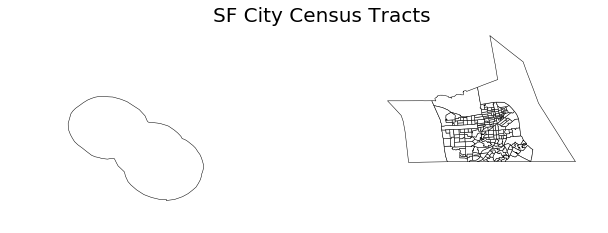

In [21]:
f, ax = plt.subplots(1, figsize=(10, 10))
shapefile.plot(ax=ax, linewidth=0.5, color='white', edgecolor='black')
plt.title('SF City Census Tracts', fontsize=tfs)
ax.set_axis_off()
plt.show()

## Code to Add Additional Data 

In [23]:
params = {'legend.fontsize': 20}
plt.rcParams.update(params)
tfs = 20

# Save the clean dataset to a new file for reuse later
clean_link = "../../data/sf_census_tract_features_export_clean"
clean_shp_link = clean_link + ".shp"

In [24]:
def plotArcGisMap(variable, bin_n, poly, cmap='YlOrRd'):
    f, ax = plt.subplots(1, figsize=(11, 11))
    
    map = pickle.load(open(pickle_map_name,'rb')) 
    map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=1000, zorder=0)

    patches = poly['poly'].map(lambda x: PolygonPatch(x, 
                                                      edgecolor='white', 
                                                      linewidth=0.75, 
                                                      zorder=10))
    patches = PatchCollection(patches, match_original=True, zorder=10)
    
    cmap = plt.get_cmap(cmap)
    norm = Normalize()

    min_value = min(variable)
    max_value = max(variable)
    
    # impose our colour map onto the patch collection
    patches.set_facecolor(cmap(norm(variable)))    
    patches.set_alpha(0.5)
    ax.add_collection(patches)
    
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(min_value, max_value)
    colorbar = plt.colorbar(mappable,fraction=0.0475, pad=0.01)
    colorbar.set_ticks(np.linspace(start=min_value, 
                                   stop=max_value, 
                                   num=bin_n))
    colorbar.set_ticklabels(np.round(np.linspace(start=min_value, 
                                                 stop=max_value, 
                                                 num=bin_n)),1)

    map.drawmapscale(
        coords[0] + 0.48, coords[1] + 0.025,
        coords[0], coords[1], 10.,
        barstyle='fancy', labelstyle='simple',
        fillcolor1='w', fillcolor2='#555555',
        fontcolor='#FFFFFF',
        zorder=5)

    plt.show()
    
def plotArcGisCentroidMap(poly, centroids, cmap='YlOrRd'):
    f, ax = plt.subplots(1, figsize=(20, 20))
    
    map = pickle.load(open(pickle_map_name,'rb')) 
    map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=1000, zorder=0)

    patches = poly['poly'].map(lambda x: PolygonPatch(x, edgecolor='black', 
                                                      linewidth=0.75, zorder=10))
    patches = PatchCollection(patches, match_original=True, zorder=5)
    
        # impose our colour map onto the patch collection
    patches.set_facecolor('w')    
    patches.set_alpha(0.8)
    ax.add_collection(patches)
    
    plt.plot(centroids[:,0], centroids[:,1],'.', color='b', zorder=10)

    map.drawmapscale(
        coords[0] + 0.48, coords[1] + 0.025,
        coords[0], coords[1], 10.,
        barstyle='fancy', labelstyle='simple',
        fillcolor1='w', fillcolor2='#555555',
        fontcolor='#FFFFFF',
        zorder=5)

    plt.show()
    
def plotArcGisNeighbourMap(poly, centroids, grouping, cmap='YlOrRd'):
    f, ax = plt.subplots(1, figsize=(20, 20))
    
    map = pickle.load(open(pickle_map_name,'rb')) 
    map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=1000, zorder=0)

    patches = poly['poly'].map(lambda x: PolygonPatch(x, edgecolor='black', 
                                                      linewidth=0.75, zorder=10))
    patches = PatchCollection(patches, match_original=True, zorder=5)
    
    # impose our colour map onto the patch collection
    patches.set_facecolor('w')    
    patches.set_alpha(0.8)
    ax.add_collection(patches)
    
    plt.plot(centroids[:,0], centroids[:,1],'.', color='b', zorder=10)
    for k,neighs in grouping.neighbors.items():
        origin = centroids[k]
        for neigh in neighs:
            segment = centroids[[k,neigh]]
            plt.plot(segment[:,0], segment[:,1], '-', zorder=10)

    map.drawmapscale(
        coords[0] + 0.48, coords[1] + 0.025,
        coords[0], coords[1], 10.,
        barstyle='fancy', labelstyle='simple',
        fillcolor1='w', fillcolor2='#555555',
        fontcolor='#FFFFFF',
        zorder=5)

    plt.show()

In [ ]:
## need to add data and then can run this
knn = ps.knnW_from_shapefile(clean_shp_link, k=4)
self_and_neighbors = [0]
self_and_neighbors.extend(knn.neighbors[0])
print(self_and_neighbors)
map_tracts_info.loc[self_and_neighbors]

In [ ]:
qW = ps.queen_from_shapefile(clean_shp_link)

In [ ]:
rW = ps.rook_from_shapefile(clean_shp_link)